In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import calendar as calendar
import datetime
sb.set()

In [2]:
df = pd.read_csv('carpark_availability_cleaned.csv')
holidays_df = pd.read_csv('sg_holidays.csv')
carpark_info = pd.read_csv('carpark_info_cleaned.csv')

In [3]:
df['update_datetime']= pd.to_datetime(df['update_datetime'])
df = df.drop(columns=['total_lots'])
df.head()

,carpark_number,update_datetime,lots_available,hour_delta,day,hour,carpark_index,holiday
0,J70,2018-01-01 00:00:00,0,0.0,0,0,0,1
1,J70,2018-01-01 01:00:00,0,1.0,0,1,0,0
2,J70,2018-01-01 02:00:00,0,2.0,0,2,0,0
3,J70,2018-01-01 03:00:00,0,3.0,0,3,0,0
4,J70,2018-01-01 04:00:00,0,4.0,0,4,0,0


In [4]:
carpark_arr = df.carpark_number.unique()

# Split Test/Train Data

In [5]:
tempDf = df.copy()
tempDf.insert(0, 'id', range(0, len(tempDf)))

trainDf = pd.DataFrame()
# Split Data based on individual carpark, day and hour
for carpark_num in range(len(carpark_arr)):
    print("Parsing " + carpark_arr[carpark_num])
    for days in range(0,7):
        for hours in range(0,24):
            trainDf = pd.concat([trainDf, tempDf[(tempDf['carpark_number'] == carpark_arr[carpark_num]) & (tempDf['day'] == days) & (tempDf['hour'] == hours)].sample(frac=0.8,random_state=500)]) # Train
#     trainDf = pd.concat([trainDf, tempDf[(tempDf['carpark_number'] == carpark_arr[carpark_num])].sample(frac=0.8,random_state=500)]) # Train
print("Completed")

Parsing J70
Parsing J85M
Parsing J72
Parsing J69
Parsing JM31
Parsing J62M
Parsing J63
Parsing J83M
Parsing J67
Parsing JM2
Completed


In [7]:
trainDf.head(5)

,id,carpark_number,update_datetime,lots_available,hour_delta,day,hour,carpark_index,holiday
4200,4200,J70,2018-06-25,0,4200.0,0,0,0,0
32240,32240,J70,2021-09-06,0,32256.0,0,0,0,0
14448,14448,J70,2019-08-26,0,14448.0,0,0,0,0
33416,33416,J70,2021-10-25,0,33432.0,0,0,0,0
34921,34921,J70,2021-12-27,0,34944.0,0,0,0,0


In [9]:
testDf = tempDf[~tempDf['id'].isin(trainDf['id'])] #Test
testDf.head(5)

,id,carpark_number,update_datetime,lots_available,hour_delta,day,hour,carpark_index,holiday
199,199,J70,2018-01-09 07:00:00,17,199.0,1,7,0,0
336,336,J70,2018-01-15 00:00:00,0,336.0,0,0,0,0
337,337,J70,2018-01-15 01:00:00,0,337.0,0,1,0,0
338,338,J70,2018-01-15 02:00:00,0,338.0,0,2,0,0
339,339,J70,2018-01-15 03:00:00,0,339.0,0,3,0,0


In [10]:
trainDf = trainDf.drop(columns=['id'])
testDf = testDf.drop(columns=['id'])
trainDf = trainDf.reset_index(drop=True)
testDf = testDf.reset_index(drop=True)

In [11]:
print("Train Shape: " + str(trainDf.shape))
print("Test Shape: " + str(testDf.shape))

Train Shape: (280160, 8)
Test Shape: (70034, 8)


# Train Using Decision Tree Regressor

# Train Using Decision Tree Regressor Individual

In [12]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict

In [13]:
dtreg_predictions = {} # Dictionary for Decision Tree Models

dtreg_CV = pd.DataFrame(columns=["carpark","trainCV","testCV"])

for carpark in carpark_arr:
    dtreg = DecisionTreeRegressor(random_state=0, max_depth=6)
    # print("Training " + carpark)
    trainDf2 = trainDf[trainDf['carpark_number'] == carpark]
    testDf2 = testDf[testDf['carpark_number'] == carpark]

    trainX = trainDf2[['day','hour']]
    trainY = trainDf2['lots_available'].values

    testX = testDf2[['day','hour']]
    testY = testDf2['lots_available'].values

    model_dtreg = dtreg.fit(trainX,trainY)
#     print("Carpark " + str(carpark_arr[0]) + " 10-K Fold Cross Validation:" )
    
    cv10_score = cross_val_score(model_dtreg,trainX, trainY, scoring="r2", cv=10)
#     print("Train K-Fold Average: " + np.mean(cv10_score))
    
    pred_score = cross_val_score(model_dtreg,  testX, testY, scoring="r2", cv=10)
    print(pred_score)
#     print("Test K-Fold Average: " + np.mean(pred_score))

    
    dtreg_append = {'carpark':carpark, 'trainCV': np.mean(cv10_score), 'testCV': np.mean(pred_score)}
    dtreg_CV = dtreg_CV.append(dtreg_append,ignore_index=True)
    
    #   Take Average Of Data For Graph Plotting
    testDf2 = testDf2.groupby(['day','hour'], as_index = False)['lots_available'].mean()

    testX = testDf2[['day','hour']]
    testY = testDf2['lots_available'].values
    
    predict_Y = cross_val_predict(model_dtreg, testX, testY)
    
#     predict_Y = model_dtreg.predict(testX)
    
    testDf2["predicted_lots"] = predict_Y.tolist()

    testDf2['day_hour'] = testDf2['day'].astype(str) + "-" + testDf2['hour'].astype(str)

    dtreg_predictions[carpark] = testDf2.copy()

with pd.option_context('display.max_rows', None,
                   'display.max_columns', None,
                   'display.width', 1000,
                   'display.precision', 3,
                   'display.colheader_justify', 'center'):
    print("Cross-validation 10-Folds Average")
    display(dtreg_CV)

[0.57428519 0.48540756 0.37367924 0.13709876 0.56755231 0.56827305
 0.78298128 0.88856875 0.73385836 0.35114165]
[-0.22097875 -0.24520601 -1.54205436 -3.44946296 -1.68609653 -0.68484968
  0.53834723  0.64871682  0.61285766  0.50574552]
[ 0.52213136  0.49954209  0.57760312  0.52922952  0.44261632 -1.65379773
  0.65465573  0.59098171  0.55274634  0.74068974]
[-2.32939523 -2.65455668 -2.01737888 -1.12114458  0.13806136 -0.84146307
 -0.53372335 -0.59827692 -0.9060866  -0.41423515]
[-4.08326648e-01 -6.34955059e-03 -1.03452025e-01  7.15692389e-02
 -1.26964868e+00 -2.17996949e-02 -4.02219636e-01 -9.49952622e-01
 -4.46093795e+00 -1.15475120e+01]
[ -4.21757938  -0.07302674  -0.97307959 -11.27374788  -0.42141262
  -0.16083992  -2.5902849   -3.24164519  -1.42329649  -2.19947555]
[0.85486259 0.78904411 0.39124542 0.2171912  0.28380291 0.42962988
 0.73013463 0.78078826 0.53826397 0.91387899]
[-3.74973674 -5.20244355 -7.99424982 -4.16576935 -4.71468479 -4.92049379
 -1.88978604 -1.89795139 -2.5683114

,carpark,trainCV,testCV
0,J70,0.319,0.546
1,J85M,0.198,-0.552
2,J72,0.479,0.346
3,J69,0.112,-1.128
4,JM31,0.041,-1.910
5,J62M,0.059,-2.657
6,J63,0.465,0.593
7,J83M,0.082,-3.967
8,J67,0.017,-0.095
9,JM2,0.146,-1285.294


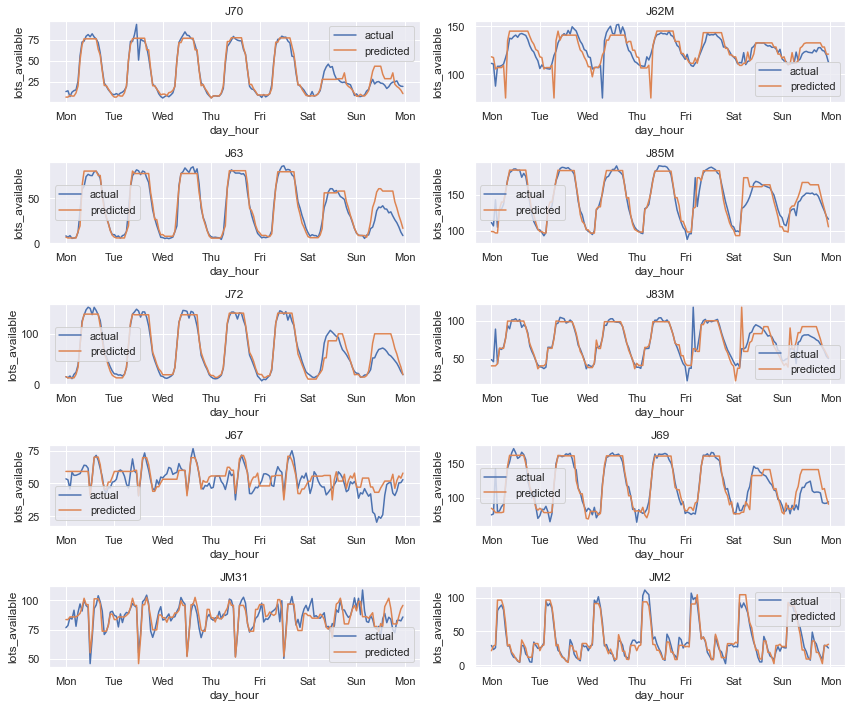

In [14]:
rows = int(len(carpark_arr)/2)
fig, axis = plt.subplots(nrows=rows, ncols=2)
fig.set_size_inches(12, 10)

fig.tight_layout()

i = 0
for carpark in dtreg_predictions.keys():
    dfPlot = dtreg_predictions[carpark]
    dfPlot["day_hour"] = "2022-08-" + (dfPlot['day']+1).astype(str) + " " + dfPlot["hour"].astype(str) + ":0:0"
    dfPlot["day_hour"] = pd.to_datetime(dfPlot["day_hour"], format= "%Y-%m-%d %H:%M:%S")
    date_format =  mdates.DateFormatter("%a")
    lp1 = sb.lineplot(x='day_hour',y='lots_available', legend='brief', label="actual",data=dfPlot, ax=axis[i%rows,i%2])
    lp2 = sb.lineplot(x='day_hour',y='predicted_lots', legend='brief', label="predicted",data=dfPlot, ax=axis[i%rows,i%2])
    lp1.set(title=str(carpark_arr[i]))
    lp1.xaxis.set_major_formatter(date_format)
    lp2.xaxis.set_major_formatter(date_format)
    
    i = i + 1
fig.tight_layout()

# Auto ARIMA

In [15]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

In [22]:
# Create Sections of Date for Forward Chaining Cross Validation
sortDf = df.copy()
sortDf = sortDf.sort_values(by=['update_datetime'])
sortDf = sortDf.reset_index(drop=True)
sortDf = sortDf.drop(columns=["day","hour","hour_delta","holiday","carpark_index"])


start = sortDf['update_datetime'].min()
end = sortDf['update_datetime'].max()

start_date = datetime.date(start.year, start.month, start.day)
daysInRange = (end-start)

split = daysInRange/5

split_end = []
split_start = []
split_start.append(start.strftime("%Y-%m-%d"))
for i in range(1,6):
    split_end.append((start_date + split * i).strftime("%Y-%m-%d"))
    split_start.append((datetime.datetime.strptime(split_end[i-1],"%Y-%m-%d")+timedelta(days=1)).strftime("%Y-%m-%d"))

split_start.pop(len(split_start)-1) 
print(split_start)
print(split_end)

['2018-01-01', '2018-10-21', '2019-08-09', '2020-05-27', '2021-03-15']
['2018-10-20', '2019-08-08', '2020-05-26', '2021-03-14', '2021-12-31']


In [23]:
forward_chain = []
for i in range(0, len(split_start)):
    start = split_start[i]
    end = split_end[i]
    forward_chain.append(sortDf[(sortDf['update_datetime'] >= start) & (sortDf['update_datetime'] <= end)].copy())

In [24]:

for i in range(0, 1):
    arima_df = forward_chain[0].copy()
    arima_df = arima_df[arima_df['carpark_number'] == carpark_arr[1]]
    for j in range (1, i):
        arima_df = pd.concat(arima_df, forward_chain[j])

    arima_df = arima_df.drop(columns=["carpark_number"])
    arima_df.sort_values(by=["update_datetime"],ignore_index=True)
    arima_df = arima_df.set_index("update_datetime")
    arima_df = arima_df.sort_index()
    
    display(arima_df)
    arima_model =  pm.auto_arima(arima_df, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # No need difference, data already stationary
                      seasonal=False,   # Not calculating seasonality
                      start_P=0, 
                      D=0, 
                      trace=False,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
        

,lots_available
update_datetime,
2018-01-01 00:00:00,187
2018-01-01 01:00:00,176
2018-01-01 02:00:00,172
2018-01-01 03:00:00,166
2018-01-01 04:00:00,215
...,...
2018-10-19 20:00:00,147
2018-10-19 21:00:00,133
2018-10-19 22:00:00,119
